# 100 features(33 related)

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    W1 = np.random.normal(loc=0, scale=1, size=(input_size, hidden_size))
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.normal(loc=0, scale=1, size=(hidden_size, output_size))
    b2 = np.zeros((1, output_size))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

def forward_propagation(X, parameters):
    Z1 = np.dot(X, parameters['W1']) + parameters['b1']
    A1 = relu(Z1)
    Z2 = np.dot(A1, parameters['W2']) + parameters['b2']
    A2 = sigmoid(Z2)
    return {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

def predict(X, parameters):
    forward = forward_propagation(X, parameters)
    return (forward['A2'] > 0.5).astype(int)

# Set up neural network parameters
input_size = 100
hidden_size = 264
output_size = 1

# Generate random input data
np.random.seed(42)
n_samples = 500

# Generate the first 33 variables using the neural network
X_first_33 = np.random.normal(loc=0, scale=1, size=(n_samples, 33))
parameters = initialize_parameters(33, hidden_size, output_size)
forward = forward_propagation(X_first_33, parameters)
y_neural_network = forward['A2']

# Generate random values for the remaining variables
X_rest = np.random.normal(loc=0, scale=1, size=(n_samples, input_size - 33))

# Combine the generated values
X = np.concatenate((X_first_33, X_rest), axis=1)

# Threshold for binary classification
threshold = 0.5
y_binary_neural_network = (y_neural_network > threshold).astype(int)

# Add the generated y values to the existing DataFrame
data = pd.DataFrame(X, columns=[f'var{i}' for i in range(input_size)])
data['y'] = y_binary_neural_network

# Print the DataFrame
print(data.head())

       var0      var1      var2      var3      var4      var5      var6  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1 -1.057711  0.822545 -1.220844  0.208864 -1.959670 -1.328186  0.196861   
2 -0.072010  1.003533  0.361636 -0.645120  0.361396  1.538037 -0.035826   
3 -0.234587 -1.415371 -0.420645 -0.342715 -0.802277 -0.161286  0.404051   
4 -1.062304  0.473592 -0.919424  1.549934 -0.783253 -0.322062  0.813517   

       var7      var8      var9  ...     var91     var92     var93     var94  \
0  0.767435 -0.469474  0.542560  ... -0.029352  0.395307  0.033023  1.346941   
1  0.738467  0.171368 -0.115648  ...  1.021963  0.733179  1.378143 -0.990623   
2  1.564644 -2.619745  0.821903  ...  0.272634  0.342226 -1.098679  0.044570   
3  1.886186  0.174578  0.257550  ... -1.312467  0.536389 -1.671147 -0.838362   
4 -1.230864  0.227460  1.307143  ...  0.534347 -1.768415  0.995168  0.937367   

      var95     var96     var97     var98     var99  y  
0  0.774023

In [59]:
import numpy as np
from scipy.sparse.linalg import eigsh

## some useful functions
def get_arccos(X):
    # X is a 2-d array
    n, p = X.shape
    cos_a = np.zeros([n, n, n])
    
    for r in range(n):
        
        xr = X[r]
        X_r = X - xr
        cross = np.dot(X_r, X_r.T)
        row_norm = np.sqrt(np.sum(X_r**2, axis = 1))
        outer_norm = np.outer(row_norm, row_norm)
        
        zero_idx = (outer_norm == 0.)
        outer_norm[zero_idx] = 1.
        cos_a_kl = cross / outer_norm
        cos_a_kl[zero_idx] = 0.

        cos_a[:,:,r] = cos_a_kl
        
    cos_a[cos_a > 1] = 1.
    cos_a[cos_a < -1] = -1.
    a = np.arccos(cos_a)

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
        
    return a, A

def get_arccos_1d(X):
    # X is a 1-d array
    
    X = np.squeeze(X)
    Y = X[:,None] - X
    Z = Y.T[:,:,None]*Y.T[:,None]
    n = len(X)
    
    a = np.zeros([n, n, n])
    a[Z == 0.] = np.pi/2.
    a[Z < 0.] = np.pi
    
    a = np.transpose(a, (1,2,0))
    
    #a = Z[Z>0.]*0. + Z[Z==0.]*np.pi/2. + Z[Z<0.]*np.pi

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
    
    return a, A

def orthonormalize(X):
    # X is a 2-d array
    # output: Gram-Schmidt orthogonalization of X
    
    n, p = X.shape
    Y = np.zeros([n,p])
    Y[:,0] = X[:,0]/np.sqrt(np.sum(X[:,0]**2))
    
    for j in range(1,p):
        
        Yj = Y[:,range(j)]
        xj = X[:,j]
        w = np.dot(xj, Yj)
        xj_p = np.sum(w*Yj, axis = 1)
        yj = xj - xj_p
        yj = yj/np.sqrt(np.sum(yj**2))
        
        Y[:,j] = yj
        
    return Y

# Main functions
def projection_corr(X, Y):
    # X, Y are 2-d array
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1d(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos_1d(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1dy(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def get_equi_features(X):
    # X is 2-d array
    
    n, p = X.shape
    scale = np.sqrt(np.sum(X**2, axis=0))
    Xstd = X / scale
    sigma = np.dot(Xstd.T, Xstd)
    sigma_inv = np.linalg.inv(sigma)
    lambd_min = eigsh(sigma, k=1, which='SA')[0].squeeze()
    sj = np.min([1., 2.*lambd_min])
    sj = sj - 0.00001
    
    mat_s = np.diag([sj]*p)
    A = 2*mat_s - sj*sj*sigma_inv
    C = np.linalg.cholesky(A).T
    
    Xn = np.random.randn(n, p)
    XX = np.hstack([Xstd, Xn])
    XXo = orthonormalize(XX)
    U = XXo[:,range(p,2*p)]
    
    Xnew = np.dot(Xstd,  np.eye(p) - sigma_inv*sj) + np.dot(U,C)
    return Xnew

In [60]:
X = data.iloc[:,:-1]
X = (X - X.mean()) / X.std()
Y = data.iloc[:,-1]
X_knockoff = get_equi_features(X)
X_knockoff = (X_knockoff - X_knockoff.mean()) / X_knockoff.std()

In [61]:
X_knockoff_df = pd.DataFrame(X_knockoff)
column_names = ['feature0_k', 'feature1_k', 'feature2_k', 'feature3_k', 'feature4_k','feature5_k', 'feature6_k', 'feature7_k', 'feature8_k', 'feature9_k',
                'feature10_k', 'feature11_k', 'feature12_k', 'feature13_k', 'feature14_k','feature15_k', 'feature16_k', 'feature17_k', 'feature18_k', 'feature19_k',
                'feature20_k', 'feature21_k', 'feature22_k', 'feature23_k', 'feature24_k','feature25_k', 'feature26_k', 'feature27_k', 'feature28_k', 'feature29_k',
                'feature30_k', 'feature31_k', 'feature32_k', 'feature33_k', 'feature34_k','feature35_k', 'feature36_k', 'feature37_k', 'feature38_k', 'feature39_k',
                'feature40_k', 'feature41_k', 'feature42_k', 'feature43_k', 'feature44_k','feature45_k', 'feature46_k', 'feature47_k', 'feature48_k', 'feature49_k',
                'feature50_k', 'feature51_k', 'feature52_k', 'feature53_k', 'feature54_k','feature55_k', 'feature56_k', 'feature57_k', 'feature58_k', 'feature59_k',
                'feature60_k', 'feature61_k', 'feature62_k', 'feature63_k', 'feature64_k','feature65_k', 'feature66_k', 'feature67_k', 'feature68_k', 'feature69_k',
                'feature70_k', 'feature71_k', 'feature72_k', 'feature73_k', 'feature74_k','feature75_k', 'feature76_k', 'feature77_k', 'feature78_k', 'feature79_k',
                'feature80_k', 'feature81_k', 'feature82_k', 'feature83_k', 'feature84_k','feature85_k', 'feature86_k', 'feature87_k', 'feature88_k', 'feature89_k',
                'feature90_k', 'feature91_k', 'feature92_k', 'feature93_k', 'feature94_k','feature95_k', 'feature96_k', 'feature97_k', 'feature98_k', 'feature99_k']
X_knockoff_df.columns = column_names
feature = pd.concat([X,X_knockoff_df],axis = 1)
feature.to_csv('data_feature.csv', index=False)
Y.to_csv('data_Y.csv', index=False)
feature

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,feature90_k,feature91_k,feature92_k,feature93_k,feature94_k,feature95_k,feature96_k,feature97_k,feature98_k,feature99_k
0,0.461406,-0.138062,0.678772,1.527778,-0.218823,-0.145966,1.500183,0.711481,-0.433734,0.501047,...,-0.305115,-0.979433,0.463950,-0.384183,0.512113,0.015657,-0.690012,-0.558037,-0.565508,2.721553
1,-1.059556,0.807638,-1.180781,0.244734,-2.025435,-1.232025,0.165041,0.682626,0.208686,-0.157825,...,-1.235588,-1.279174,0.652524,-0.121155,-0.345293,1.321991,0.690405,0.350790,0.369794,0.931040
2,-0.095075,0.985780,0.394094,-0.589024,0.404716,1.613266,-0.059700,1.505561,-2.589300,0.780671,...,-0.170498,0.694236,0.497791,0.024633,0.594199,-0.417800,-1.647849,0.540547,0.611145,-0.013600
3,-0.254152,-1.395087,-0.384428,-0.293781,-0.813647,-0.073646,0.365155,1.825841,0.211904,0.215750,...,1.329085,-2.084411,1.355300,-0.607549,-0.210499,1.020312,-0.815541,-1.246425,-1.357394,0.573031
4,-1.064050,0.464173,-0.880810,1.554045,-0.793729,-0.233248,0.760637,-1.278976,0.264916,1.266400,...,0.617786,1.040937,-1.547896,1.017070,-0.096840,2.970988,-1.034747,0.388984,1.671235,-0.286414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-2.719838,0.245937,-0.380494,-0.174807,-0.923690,-0.060646,1.319356,-0.497589,1.004847,-0.849204,...,2.148646,-1.261415,1.671708,1.207839,3.024718,3.153122,0.406847,-0.757302,-1.000496,0.115265
496,-1.249367,0.019293,0.859484,0.192001,0.329237,1.219954,-0.738992,-0.272049,1.675527,-0.239070,...,-0.945958,1.068995,-1.610087,1.177215,-1.067030,-0.069279,-0.856657,0.215517,-0.481231,1.749924
497,0.559587,0.877735,1.646569,1.005932,0.093156,-1.212238,0.125245,0.202628,0.747672,1.313196,...,-0.681832,0.004768,0.109657,-0.461855,1.119496,0.730847,-1.192008,1.568252,-0.299782,-0.661093
498,-1.515261,0.175513,0.699545,-1.373012,-0.187130,0.797151,-2.858676,1.277270,0.391446,0.675390,...,-1.134442,0.115898,0.706394,0.489416,-1.144433,1.015803,0.695032,0.517188,-1.165706,2.305960


## Optimizers Selection

In [12]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 超参数
LR = 0.01
BATCH_SIZE = 64
EPOCH = 50

# 神经网络定义
class Net(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden)
        self.output = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.output(x)
        return torch.sigmoid(x)

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

feature1 = np.array(feature)
feature1 = torch.Tensor(feature1)

y1 = torch.Tensor(Y)
y1 = y1.view(-1, 1)

torch_dataset = TensorDataset(feature1, y1)
loader = DataLoader(dataset=torch_dataset, batch_size=32, shuffle=True)

net_SGD = Net(200, 264, 1)
net_Momentum = Net(200, 264, 1)
net_RMSprop = Net(200, 264, 1)
net_Adam = Net(200, 264, 1)
net_Adagrad = Net(200, 264, 1)
net_Adadelta = Net(200, 264, 1)

In [9]:
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam, net_Adagrad, net_Adadelta]

optimizer_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
optimizer_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
optimizer_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
optimizer_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizer_Adagrad = torch.optim.Adagrad(net_Adagrad.parameters(), lr=LR)
optimizer_Adadelta = torch.optim.Adadelta(net_Adadelta.parameters(), lr=LR, rho=0.9, eps=1e-06)

optimzers = [optimizer_SGD, optimizer_Momentum, optimizer_RMSprop, optimizer_Adam, optimizer_Adagrad, optimizer_Adadelta]
losses_his = [[] for _ in range(len(optimzers))]

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


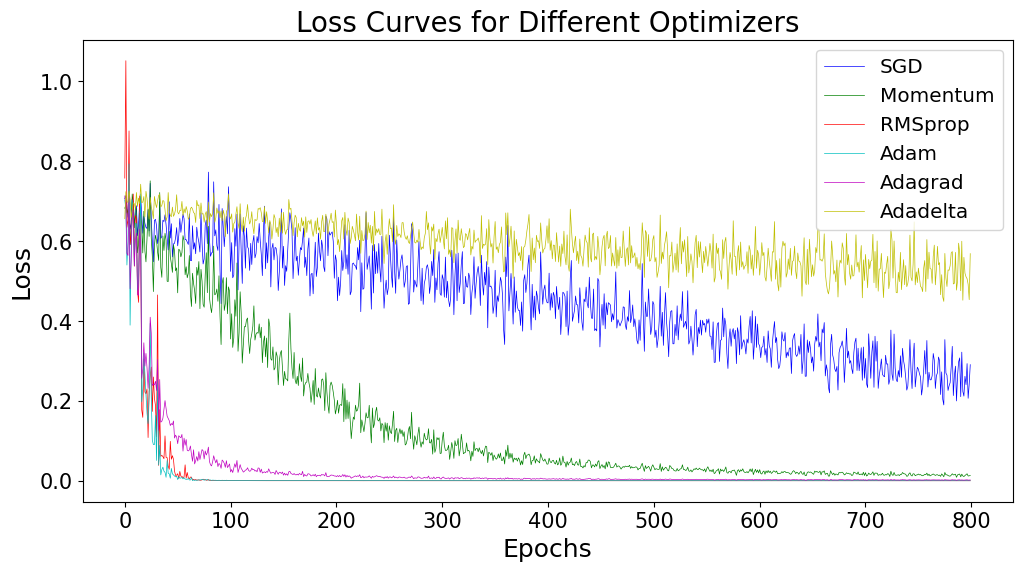

In [10]:
loss_func = nn.BCELoss()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']
for epoch in range(EPOCH):
    print(f'Epoch {epoch + 1}/{EPOCH}')
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, optimizer, loss_his in zip(nets, optimzers, losses_his):
            net_output = net(batch_x)
            loss = loss_func(net_output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_his.append(loss.item())

plt.figure(figsize=(12, 6))
for i, optimizer in enumerate(optimzers):
    plt.plot(losses_his[i],label=labels[i], lw=0.5, color=colors[i])
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large')
plt.title('Loss Curves for Different Optimizers', fontsize = 20)
plt.show()

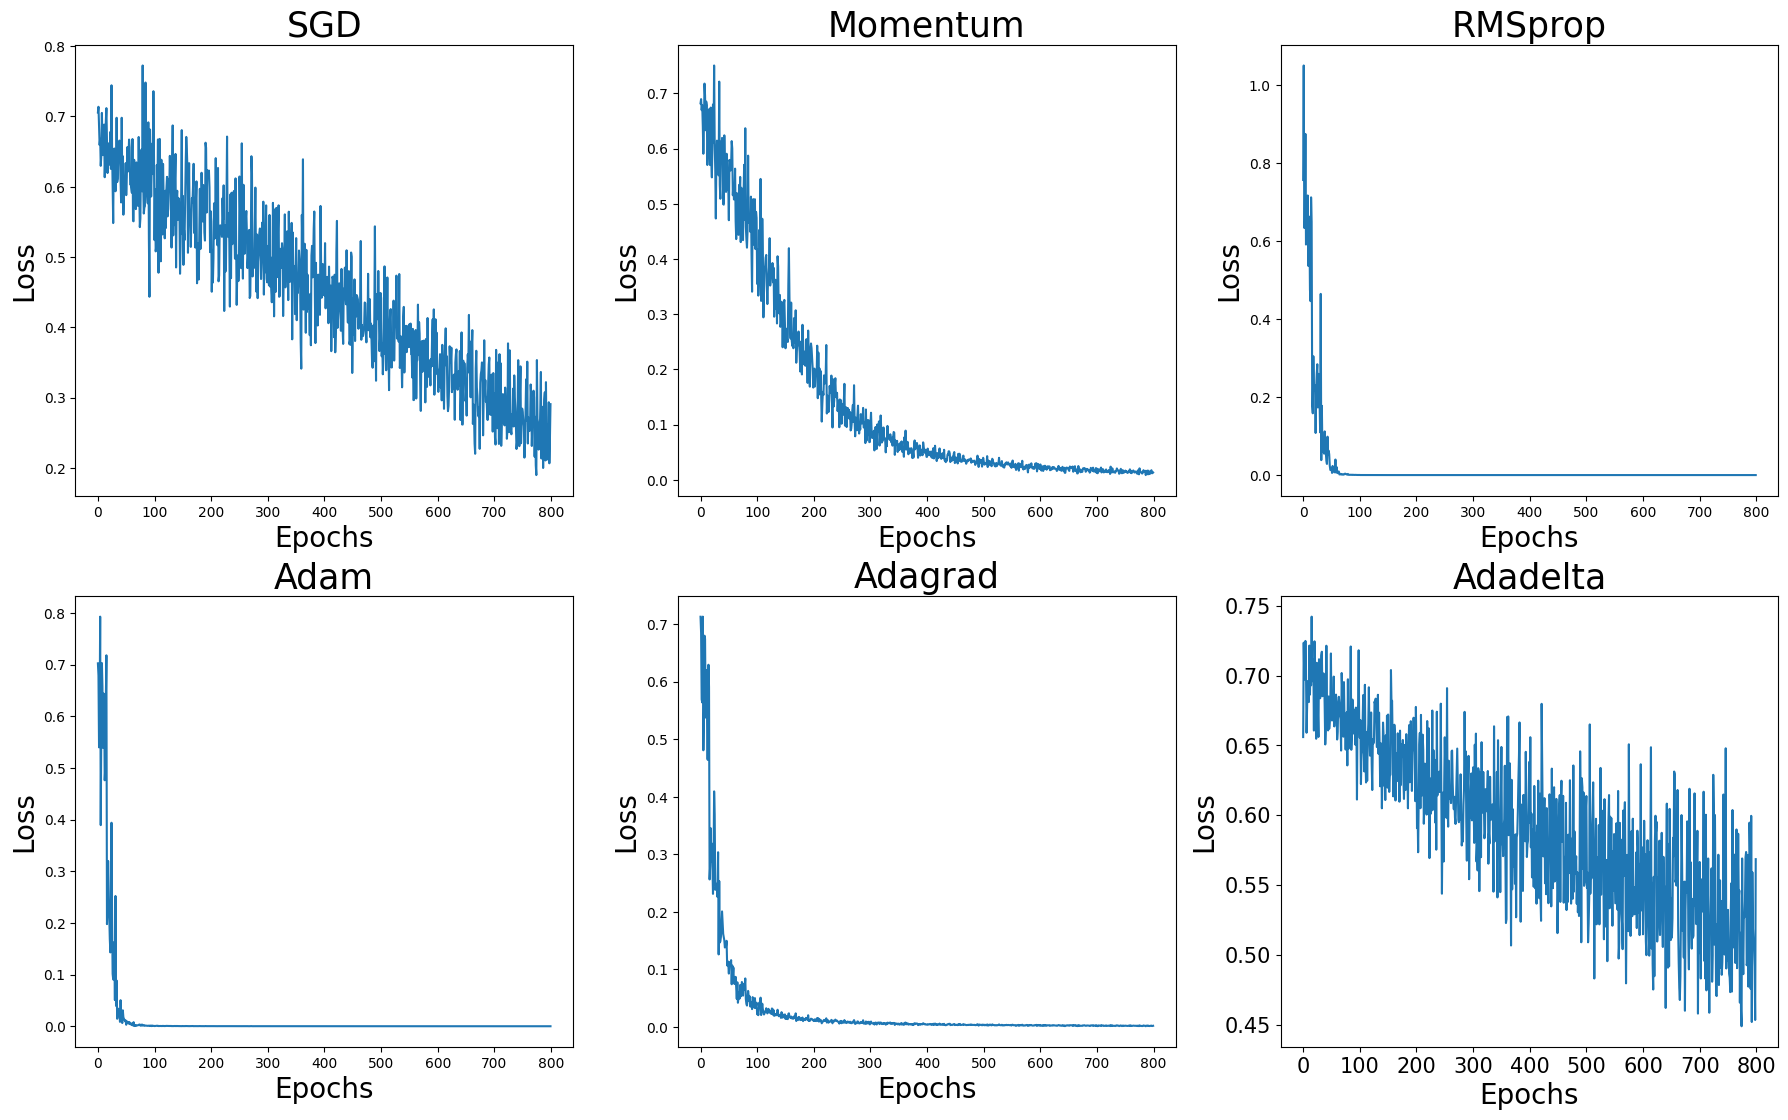

In [11]:
import matplotlib.pyplot as plt

labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (optimizer, loss_history, ax) in enumerate(zip(optimzers, losses_his, axes.flatten())):
    ax.plot(loss_history)
    ax.set_title(labels[i], fontsize = 25)
    ax.set_xlabel('Epochs', fontsize = 20)
    ax.set_ylabel('Loss', fontsize = 20)
    ax.legend()

for ax in axes.flatten():
    ax.legend().set_visible(False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [12]:
final_losses = [loss[-1] for loss in losses_his]
print("Final Losses:", final_losses)

Final Losses: [0.2905381917953491, 0.013300838880240917, 1.9495868461283372e-11, 5.866214905836387e-06, 0.0019309971248731017, 0.5684558749198914]


## Adam

### one-layer

In [217]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 5, 1):
    i = i / 20
    model = keras.Sequential()
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)

    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    for j in range(min(len(weights), len(lambda_array))):
        for n in range(min(len(weights[j]), len(lambda_array[j]))):
            if abs(weights[j][n]) < 5e-4 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.   0.05 0.1  ... 0.   0.1  0.15]
 [0.   0.05 0.1  ... 0.   0.1  0.15]
 [0.   0.05 0.1  ... 0.   0.1  0.15]
 ...
 [0.05 0.05 0.1  ... 0.05 0.1  0.1 ]
 [0.05 0.05 0.1  ... 0.1  0.1  0.15]
 [0.15 0.05 0.1  ... 0.05 0.1  0.15]]


In [221]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 1.1081118280913497e-21
绝对值最大权重值: 0.032215118408203125


In [222]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.05
绝对值最大lambda值: 5.0


In [223]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.1:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i)
t1 = min(T)
t1

1 6 0.16666666666666666
2 7 0.2857142857142857
32 44 0.7272727272727273
1 6 0.16666666666666666
0 2 0.0
30 39 0.7692307692307693
14 20 0.7
14 20 0.7
3 9 0.3333333333333333
37 45 0.8222222222222222
22 27 0.8148148148148148
2 8 0.25
3 10 0.3
0 1 0.0
23 27 0.8518518518518519
30 37 0.8108108108108109
0 3 0.0
1 4 0.25
27 28 0.9642857142857143
3 10 0.3
37 47 0.7872340425531915
5 12 0.4166666666666667
41 54 0.7592592592592593
20 23 0.8695652173913043
41 53 0.7735849056603774
37 47 0.7872340425531915
28 34 0.8235294117647058
20 23 0.8695652173913043
42 54 0.7777777777777778
36 44 0.8181818181818182
26 27 0.9629629629629629
40 52 0.7692307692307693
7 14 0.5
30 40 0.75
38 49 0.7755102040816326
5 11 0.45454545454545453
0 3 0.0
25 27 0.9259259259259259
6 12 0.5
5 12 0.4166666666666667
35 44 0.7954545454545454
10 16 0.625
22 25 0.88
32 44 0.7272727272727273
32 41 0.7804878048780488
16 21 0.7619047619047619
32 42 0.7619047619047619
43 55 0.7818181818181819
32 43 0.7441860465116279
17 21 0.8095238095

0.063675

In [224]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 2, 4, 5, 14, 17, 18], array([24749.846], dtype=float32))

## Adagrad

In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 2, 1):
    i = i / 20
    model = keras.Sequential()
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-3 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.   0.   0.   ... 0.05 0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


In [82]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 2.0418692656676285e-06
绝对值最大权重值: 0.10421296209096909


In [83]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.05


### one-layer

In [85]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i)
t1 = min(T)
t1

0 9 0.0
0 9 0.0
24 60 0.4
6 23 0.2608695652173913
6 23 0.2608695652173913
6 23 0.2608695652173913
6 23 0.2608695652173913
24 60 0.4
6 23 0.2608695652173913
0 9 0.0
32 66 0.48484848484848486
24 60 0.4
0 9 0.0
32 66 0.48484848484848486
6 23 0.2608695652173913
24 60 0.4
24 60 0.4
24 60 0.4
0 9 0.0
16 47 0.3404255319148936
6 23 0.2608695652173913
6 23 0.2608695652173913
0 9 0.0
6 23 0.2608695652173913
16 47 0.3404255319148936
24 60 0.4
24 60 0.4
16 47 0.3404255319148936
6 23 0.2608695652173913
16 47 0.3404255319148936
0 9 0.0
0 9 0.0
6 23 0.2608695652173913
24 60 0.4
16 47 0.3404255319148936
0 9 0.0
16 47 0.3404255319148936
16 47 0.3404255319148936
24 60 0.4
24 60 0.4
24 60 0.4
0 9 0.0
30 64 0.46875
30 64 0.46875
16 47 0.3404255319148936
6 23 0.2608695652173913
16 47 0.3404255319148936
6 23 0.2608695652173913
16 47 0.3404255319148936
16 47 0.3404255319148936
6 23 0.2608695652173913
16 47 0.3404255319148936
16 47 0.3404255319148936
0 9 0.0
6 23 0.2608695652173913
16 47 0.3404255319148936
6 

0.132

### Multiple-layer

In [86]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([2, 11, 24], array([63950.805], dtype=float32))

## RMSprop

In [225]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 5, 1):
    i = i / 20
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-2 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.   0.1  0.1  ... 0.05 0.1  0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]]


In [226]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.2


In [227]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 5.003756556411057e-39
绝对值最大权重值: 0.03260160982608795


### one-layer

In [228]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

0 3 0.0
0 9 0.0
12 20 0.6
0 5 0.0
0 1 0.0
28 50 0.56
10 18 0.5555555555555556
1 12 0.08333333333333333
1 11 0.09090909090909091
42 58 0.7241379310344828
13 20 0.65
0 8 0.0
3 13 0.23076923076923078
0 2 0.0
29 51 0.5686274509803921
16 23 0.6956521739130435
0 4 0.0
0 6 0.0
7 16 0.4375
6 14 0.42857142857142855
29 51 0.5686274509803921
7 15 0.4666666666666667
20 37 0.5405405405405406
16 27 0.5925925925925926
33 54 0.6111111111111112
0 7 0.0
28 45 0.6222222222222222
32 51 0.6274509803921569
33 54 0.6111111111111112
20 37 0.5405405405405406
8 16 0.5
24 42 0.5714285714285714
1 10 0.1
42 56 0.75
40 54 0.7407407407407407
15 21 0.7142857142857143
11 18 0.6111111111111112
10 18 0.5555555555555556
7 16 0.4375
4 13 0.3076923076923077
36 54 0.6666666666666666
3 13 0.23076923076923078
28 50 0.56
20 34 0.5882352941176471
20 36 0.5555555555555556
25 43 0.5813953488372093
17 31 0.5483870967741935
41 55 0.7454545454545455
33 53 0.6226415094339622
16 27 0.5925925925925926
16 22 0.7272727272727273
33 53 0.6

0.00168

### Multiple-layer

In [229]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 20, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 4, 5, 14, 17, 18], array([71.414], dtype=float32))

## Momentum

In [230]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 4, 1):
    i = i / 20
    model = keras.Sequential()
    model.add(layers.Dense(264, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-5 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [231]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.15


In [232]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 1.217772478412371e-07
绝对值最大权重值: 0.02541077323257923


### one-layer

In [233]:
lambda_array = np.where(lambda_array == 0, 100, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
33 67 0.4925373134328358
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
28 64 0.4375
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
28 64 0.4375
0 60 0.0
33 67 0.4925373134328358
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
32 65 0.49230769230769234
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
28 64 0.4375
0 60 0.0
0 60 0.0
0 60 0.0
28 64 0.4375
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
28 64 0.4375
0 60 0.0
32 65 0.49230769230769234
0 60 0.0
28 64 0.4375
0 60 0.0
0 60 0.0
0 60 0.0
28 64 0.4375
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
28 64 0.4375
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
0 60 0.0
Va

2.64

### Multiple-layer

In [234]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 20, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 4, 5, 12, 14, 17, 18], array([4674924.5], dtype=float32))

## VWA Filter

In [62]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow.keras as keras
from tensorflow.keras import layers

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

num_variables = X.shape[1]
running_times = []
accuracies = []

for x_index in range(num_variables):
    current_x = X[:, x_index].reshape(-1, 1)

    input_dim = 1
    acc = []

    for i in range(10):
        model = keras.Sequential()
        model.add(layers.Dense(264, input_shape=(input_dim,)))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        model.fit(current_x, y, epochs=50, batch_size=32, verbose=0)
        predictions = model.predict(current_x)
        predicted = (predictions > 0.5)
        accuracy = accuracy_score(y, predicted)
        end_time = time.time()
        run_time = end_time - start_time

        acc.append(accuracy)

    avg_accuracy = np.mean(acc)
    
    accuracies.append(avg_accuracy)

print("Accuracies for each variable:", accuracies)

16/16 [==============================] - 0s 2ms/step
Accuracies for each variable: [0.668, 0.6696, 0.668, 0.6682, 0.668, 0.668, 0.679, 0.669, 0.668, 0.668, 0.675, 0.6664000000000001, 0.668, 0.668, 0.668, 0.668, 0.6584, 0.668, 0.668, 0.668, 0.6688000000000001, 0.668, 0.667, 0.6686000000000001, 0.6760000000000002, 0.6688000000000001, 0.6702, 0.6901999999999999, 0.668, 0.668, 0.6674, 0.6708000000000001, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.6676, 0.6684, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.6729999999999999, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668]


### one-layer

In [6]:
accuracies = [0.668, 0.6696, 0.668, 0.6682, 0.668, 0.668, 0.679, 0.669, 0.668, 0.668, 0.675, 0.6664000000000001, 0.668, 0.668, 0.668, 0.668, 0.6584, 0.668, 0.668, 0.668, 0.6688000000000001, 0.668, 0.667, 0.6686000000000001, 0.6760000000000002, 0.6688000000000001, 0.6702, 0.6901999999999999, 0.668, 0.668, 0.6674, 0.6708000000000001, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.6676, 0.6684, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.6729999999999999, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668, 0.668]

In [10]:
from collections import defaultdict

lists = [
    [1,3,4,6,8,9,10,12,13,14,18,21,26,28,30,31,32],
    [2,4,7,10,15,17,18,19,24,29,32,33,34,35,37,39,41,42,44,46,47,50,58,59,61,62,63,64,68,69,73,78,80,83,85,86,87,88,92,93,94,96,98,99],
    [1,6],
    [1,6,8,9,10,13,14,16,25,26,28,35]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

Selected Variables: [1, 4, 6, 8, 9, 10, 13, 14, 18, 26, 28, 31, 32, 7, 24, 35, 25]


### multiple-layers

In [11]:
from collections import defaultdict

lists = [
    [1, 3, 4, 6, 8, 9, 10, 14, 26, 28],
    [3, 6, 8, 13, 14, 25],
    [9, 26],
    [28]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

Selected Variables: [1, 3, 6, 8, 9, 10, 14, 26, 28, 25]


### one-layer and multiple layers

In [9]:
from collections import defaultdict

lists = [
    [1,3,4,6,8,9,10,12,13,14,18,21,26,28,30,31,32],
    [1, 3, 4, 6, 8, 9, 10, 12, 13, 14, 18, 21, 26, 28],
    [2,4,7,10,15,17,18,19,24,29,32,33,34,35,37,39,41,42,44,46,47,50,58,59,61,62,63,64,68,69,73,78,80,83,85,86,87,88,92,93,94,96,98,99],
    [3, 6, 8, 13, 14, 25],
    [1,6],
    [9, 26],
    [1,6,8,9,10,13,14,16,25,26,28,35],
    [28]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

Selected Variables: [1, 3, 4, 6, 8, 9, 10, 12, 13, 14, 18, 21, 26, 28, 31, 32, 7, 24, 35, 25]


# 100 features(20 related)

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    W1 = np.random.normal(loc=0, scale=1, size=(input_size, hidden_size))
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.normal(loc=0, scale=1, size=(hidden_size, output_size))
    b2 = np.zeros((1, output_size))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

def forward_propagation(X, parameters):
    Z1 = np.dot(X, parameters['W1']) + parameters['b1']
    A1 = relu(Z1)
    Z2 = np.dot(A1, parameters['W2']) + parameters['b2']
    A2 = sigmoid(Z2)
    return {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

def predict(X, parameters):
    forward = forward_propagation(X, parameters)
    return (forward['A2'] > 0.5).astype(int)

# Set up neural network parameters
input_size = 100
hidden_size = 264
output_size = 1

# Generate random input data
np.random.seed(42)
n_samples = 500

# Generate the first 20 variables using the neural network
X_first_20 = np.random.normal(loc=0, scale=1, size=(n_samples, 20))
parameters = initialize_parameters(20, hidden_size, output_size)
forward = forward_propagation(X_first_20, parameters)
y_neural_network = forward['A2']

# Generate random values for the remaining variables
X_rest = np.random.normal(loc=0, scale=1, size=(n_samples, input_size - 20))

# Combine the generated values
X = np.concatenate((X_first_20, X_rest), axis=1)

# Threshold for binary classification
threshold = 0.5
y_binary_neural_network = (y_neural_network > threshold).astype(int)

# Add the generated y values to the existing DataFrame
data = pd.DataFrame(X, columns=[f'var{i}' for i in range(input_size)])
data['y'] = y_binary_neural_network

# Print the DataFrame
print(data.head())

       var0      var1      var2      var3      var4      var5      var6  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1  1.465649 -0.225776  0.067528 -1.424748 -0.544383  0.110923 -1.150994   
2  0.738467  0.171368 -0.115648 -0.301104 -1.478522 -0.719844 -0.460639   
3 -0.479174 -0.185659 -1.106335 -1.196207  0.812526  1.356240 -0.072010   
4 -0.219672  0.357113  1.477894 -0.518270 -0.808494 -0.501757  0.915402   

       var7      var8      var9  ...     var91     var92     var93     var94  \
0  0.767435 -0.469474  0.542560  ... -2.553550 -0.168385 -0.326012  0.390366   
1  0.375698 -0.600639 -0.291694  ...  0.523961 -0.399900 -0.745168 -0.104968   
2  1.057122  0.343618 -1.763040  ... -1.302845  0.452068 -0.355974  0.029191   
3  1.003533  0.361636 -0.645120  ... -1.798215 -2.223574 -0.518069 -0.300980   
4  0.328751 -0.529760  0.513267  ...  0.441747  1.227035 -1.580604  1.244565   

      var95     var96     var97     var98     var99  y  
0 -0.153905

In [64]:
import numpy as np
from scipy.sparse.linalg import eigsh

## some useful functions
def get_arccos(X):
    # X is a 2-d array
    n, p = X.shape
    cos_a = np.zeros([n, n, n])
    
    for r in range(n):
        
        xr = X[r]
        X_r = X - xr
        cross = np.dot(X_r, X_r.T)
        row_norm = np.sqrt(np.sum(X_r**2, axis = 1))
        outer_norm = np.outer(row_norm, row_norm)
        
        zero_idx = (outer_norm == 0.)
        outer_norm[zero_idx] = 1.
        cos_a_kl = cross / outer_norm
        cos_a_kl[zero_idx] = 0.

        cos_a[:,:,r] = cos_a_kl
        
    cos_a[cos_a > 1] = 1.
    cos_a[cos_a < -1] = -1.
    a = np.arccos(cos_a)

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
        
    return a, A

def get_arccos_1d(X):
    # X is a 1-d array
    
    X = np.squeeze(X)
    Y = X[:,None] - X
    Z = Y.T[:,:,None]*Y.T[:,None]
    n = len(X)
    
    a = np.zeros([n, n, n])
    a[Z == 0.] = np.pi/2.
    a[Z < 0.] = np.pi
    
    a = np.transpose(a, (1,2,0))
    
    #a = Z[Z>0.]*0. + Z[Z==0.]*np.pi/2. + Z[Z<0.]*np.pi

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
    
    return a, A

def orthonormalize(X):
    # X is a 2-d array
    # output: Gram-Schmidt orthogonalization of X
    
    n, p = X.shape
    Y = np.zeros([n,p])
    Y[:,0] = X[:,0]/np.sqrt(np.sum(X[:,0]**2))
    
    for j in range(1,p):
        
        Yj = Y[:,range(j)]
        xj = X[:,j]
        w = np.dot(xj, Yj)
        xj_p = np.sum(w*Yj, axis = 1)
        yj = xj - xj_p
        yj = yj/np.sqrt(np.sum(yj**2))
        
        Y[:,j] = yj
        
    return Y

# Main functions
def projection_corr(X, Y):
    # X, Y are 2-d array
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1d(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos_1d(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1dy(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def get_equi_features(X):
    # X is 2-d array
    
    n, p = X.shape
    scale = np.sqrt(np.sum(X**2, axis=0))
    Xstd = X / scale
    sigma = np.dot(Xstd.T, Xstd)
    sigma_inv = np.linalg.inv(sigma)
    lambd_min = eigsh(sigma, k=1, which='SA')[0].squeeze()
    sj = np.min([1., 2.*lambd_min])
    sj = sj - 0.00001
    
    mat_s = np.diag([sj]*p)
    A = 2*mat_s - sj*sj*sigma_inv
    C = np.linalg.cholesky(A).T
    
    Xn = np.random.randn(n, p)
    XX = np.hstack([Xstd, Xn])
    XXo = orthonormalize(XX)
    U = XXo[:,range(p,2*p)]
    
    Xnew = np.dot(Xstd,  np.eye(p) - sigma_inv*sj) + np.dot(U,C)
    return Xnew

In [65]:
X = data.iloc[:,:-1]
X = (X - X.mean()) / X.std()
Y = data.iloc[:,-1]
X_knockoff = get_equi_features(X)
X_knockoff = (X_knockoff - X_knockoff.mean()) / X_knockoff.std()

In [66]:
X_knockoff_df = pd.DataFrame(X_knockoff)
column_names = ['feature0_k', 'feature1_k', 'feature2_k', 'feature3_k', 'feature4_k','feature5_k', 'feature6_k', 'feature7_k', 'feature8_k', 'feature9_k',
                'feature10_k', 'feature11_k', 'feature12_k', 'feature13_k', 'feature14_k','feature15_k', 'feature16_k', 'feature17_k', 'feature18_k', 'feature19_k',
                'feature20_k', 'feature21_k', 'feature22_k', 'feature23_k', 'feature24_k','feature25_k', 'feature26_k', 'feature27_k', 'feature28_k', 'feature29_k',
                'feature30_k', 'feature31_k', 'feature32_k', 'feature33_k', 'feature34_k','feature35_k', 'feature36_k', 'feature37_k', 'feature38_k', 'feature39_k',
                'feature40_k', 'feature41_k', 'feature42_k', 'feature43_k', 'feature44_k','feature45_k', 'feature46_k', 'feature47_k', 'feature48_k', 'feature49_k',
                'feature50_k', 'feature51_k', 'feature52_k', 'feature53_k', 'feature54_k','feature55_k', 'feature56_k', 'feature57_k', 'feature58_k', 'feature59_k',
                'feature60_k', 'feature61_k', 'feature62_k', 'feature63_k', 'feature64_k','feature65_k', 'feature66_k', 'feature67_k', 'feature68_k', 'feature69_k',
                'feature70_k', 'feature71_k', 'feature72_k', 'feature73_k', 'feature74_k','feature75_k', 'feature76_k', 'feature77_k', 'feature78_k', 'feature79_k',
                'feature80_k', 'feature81_k', 'feature82_k', 'feature83_k', 'feature84_k','feature85_k', 'feature86_k', 'feature87_k', 'feature88_k', 'feature89_k',
                'feature90_k', 'feature91_k', 'feature92_k', 'feature93_k', 'feature94_k','feature95_k', 'feature96_k', 'feature97_k', 'feature98_k', 'feature99_k']
X_knockoff_df.columns = column_names
feature = pd.concat([X,X_knockoff_df],axis = 1)
feature.to_csv('data_feature.csv', index=False)
Y.to_csv('data_Y.csv', index=False)
feature

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,feature90_k,feature91_k,feature92_k,feature93_k,feature94_k,feature95_k,feature96_k,feature97_k,feature98_k,feature99_k
0,0.465445,-0.189796,0.676963,1.552321,-0.254902,-0.137138,1.611024,0.727110,-0.460502,0.505044,...,-0.672908,-1.091526,-0.241221,0.279544,0.694754,0.231996,-0.500819,-0.976104,-0.101942,0.362587
1,1.419116,-0.278775,0.101054,-1.451255,-0.559702,0.200027,-1.070815,0.339358,-0.597181,-0.379359,...,0.641249,0.688606,-0.096057,-0.162172,0.532184,-0.071335,1.489783,-1.058005,-0.959297,-0.425997
2,0.703389,0.125026,-0.080780,-0.306342,-1.477490,-0.611732,-0.392690,1.013851,0.386777,-1.939151,...,-0.340965,0.378711,0.513514,-2.173005,0.063931,1.086482,-0.350541,1.216586,0.524979,1.730399
3,-0.495069,-0.237986,-1.064206,-1.218388,0.773456,1.416851,-0.010946,0.960806,0.405552,-0.754030,...,-1.726773,-0.685816,0.176362,0.061487,0.218860,-0.038533,0.138965,0.497575,-0.595570,-0.576901
4,-0.239655,0.313884,1.501084,-0.527619,-0.819190,-0.398635,0.958973,0.292888,-0.523323,0.473990,...,0.501772,-0.213151,-0.447280,1.038925,-0.468622,0.547035,-1.084310,-0.488368,0.394025,0.373288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.896487,0.326912,-1.075118,-0.041815,0.928654,-1.137833,0.685064,2.266466,1.135172,1.428899,...,0.547862,0.117772,-1.030485,-0.170852,0.455761,0.892841,0.418412,1.146546,-0.730008,-0.204309
496,-1.036835,0.181521,-1.672312,1.067234,0.020973,-0.417333,-0.759804,-0.264712,0.745909,0.510534,...,-2.148999,0.969269,0.421710,1.116050,-0.058875,-1.211085,-1.121290,1.207946,0.863212,-0.266008
497,-0.581952,1.782511,2.041375,1.866301,-0.214451,-1.649698,-2.241742,-0.640311,-0.177690,1.308678,...,-0.097907,-0.715056,0.941010,-0.979747,-0.743134,1.034462,0.669344,0.515331,0.004261,-0.629479
498,-1.077244,-0.846682,0.717471,-0.238485,1.536484,0.581305,-0.418222,-0.042621,0.094760,-0.842306,...,-0.261499,0.641387,1.013354,0.455544,1.332723,0.613035,-0.332248,0.921119,-0.650974,-1.078706


## Optimizers Selection

In [239]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 超参数
LR = 0.01
BATCH_SIZE = 64
EPOCH = 50

# 神经网络定义
class Net(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden)
        self.output = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.output(x)
        return torch.sigmoid(x)

In [240]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

feature1 = np.array(feature)
feature1 = torch.Tensor(feature1)

y1 = torch.Tensor(Y)
y1 = y1.view(-1, 1)

torch_dataset = TensorDataset(feature1, y1)
loader = DataLoader(dataset=torch_dataset, batch_size=32, shuffle=True)

net_SGD = Net(200, 264, 1)
net_Momentum = Net(200, 264, 1)
net_RMSprop = Net(200, 264, 1)
net_Adam = Net(200, 264, 1)
net_Adagrad = Net(200, 264, 1)
net_Adadelta = Net(200, 264, 1)

In [241]:
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam, net_Adagrad, net_Adadelta]

optimizer_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
optimizer_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
optimizer_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
optimizer_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizer_Adagrad = torch.optim.Adagrad(net_Adagrad.parameters(), lr=LR)
optimizer_Adadelta = torch.optim.Adadelta(net_Adadelta.parameters(), lr=LR, rho=0.9, eps=1e-06)

optimzers = [optimizer_SGD, optimizer_Momentum, optimizer_RMSprop, optimizer_Adam, optimizer_Adagrad, optimizer_Adadelta]
losses_his = [[] for _ in range(len(optimzers))]

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


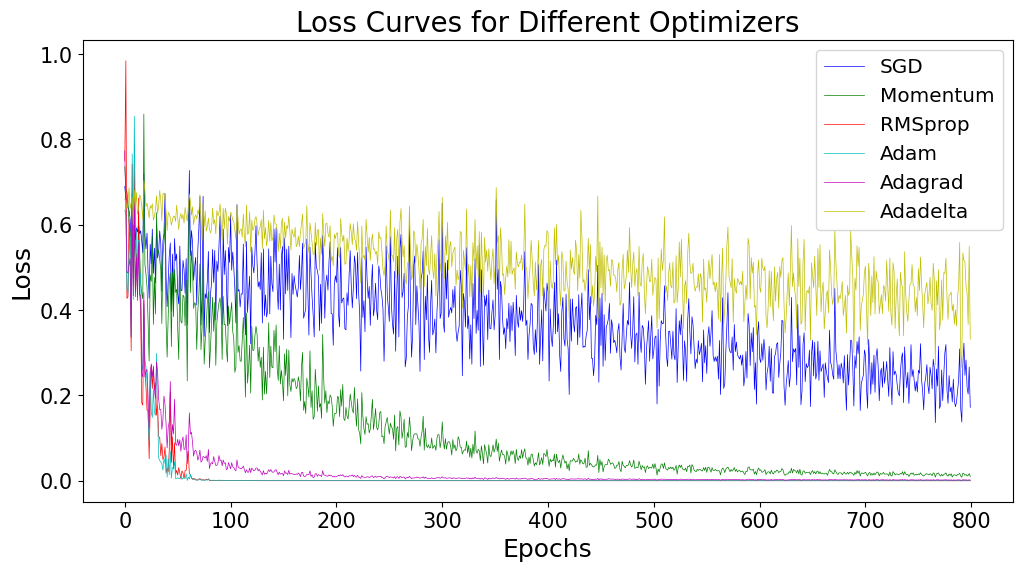

In [242]:
loss_func = nn.BCELoss()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']
for epoch in range(EPOCH):
    print(f'Epoch {epoch + 1}/{EPOCH}')
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, optimizer, loss_his in zip(nets, optimzers, losses_his):
            net_output = net(batch_x)
            loss = loss_func(net_output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_his.append(loss.item())

plt.figure(figsize=(12, 6))
for i, optimizer in enumerate(optimzers):
    plt.plot(losses_his[i],label=labels[i], lw=0.5, color=colors[i])
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large')
plt.title('Loss Curves for Different Optimizers', fontsize = 20)
plt.show()

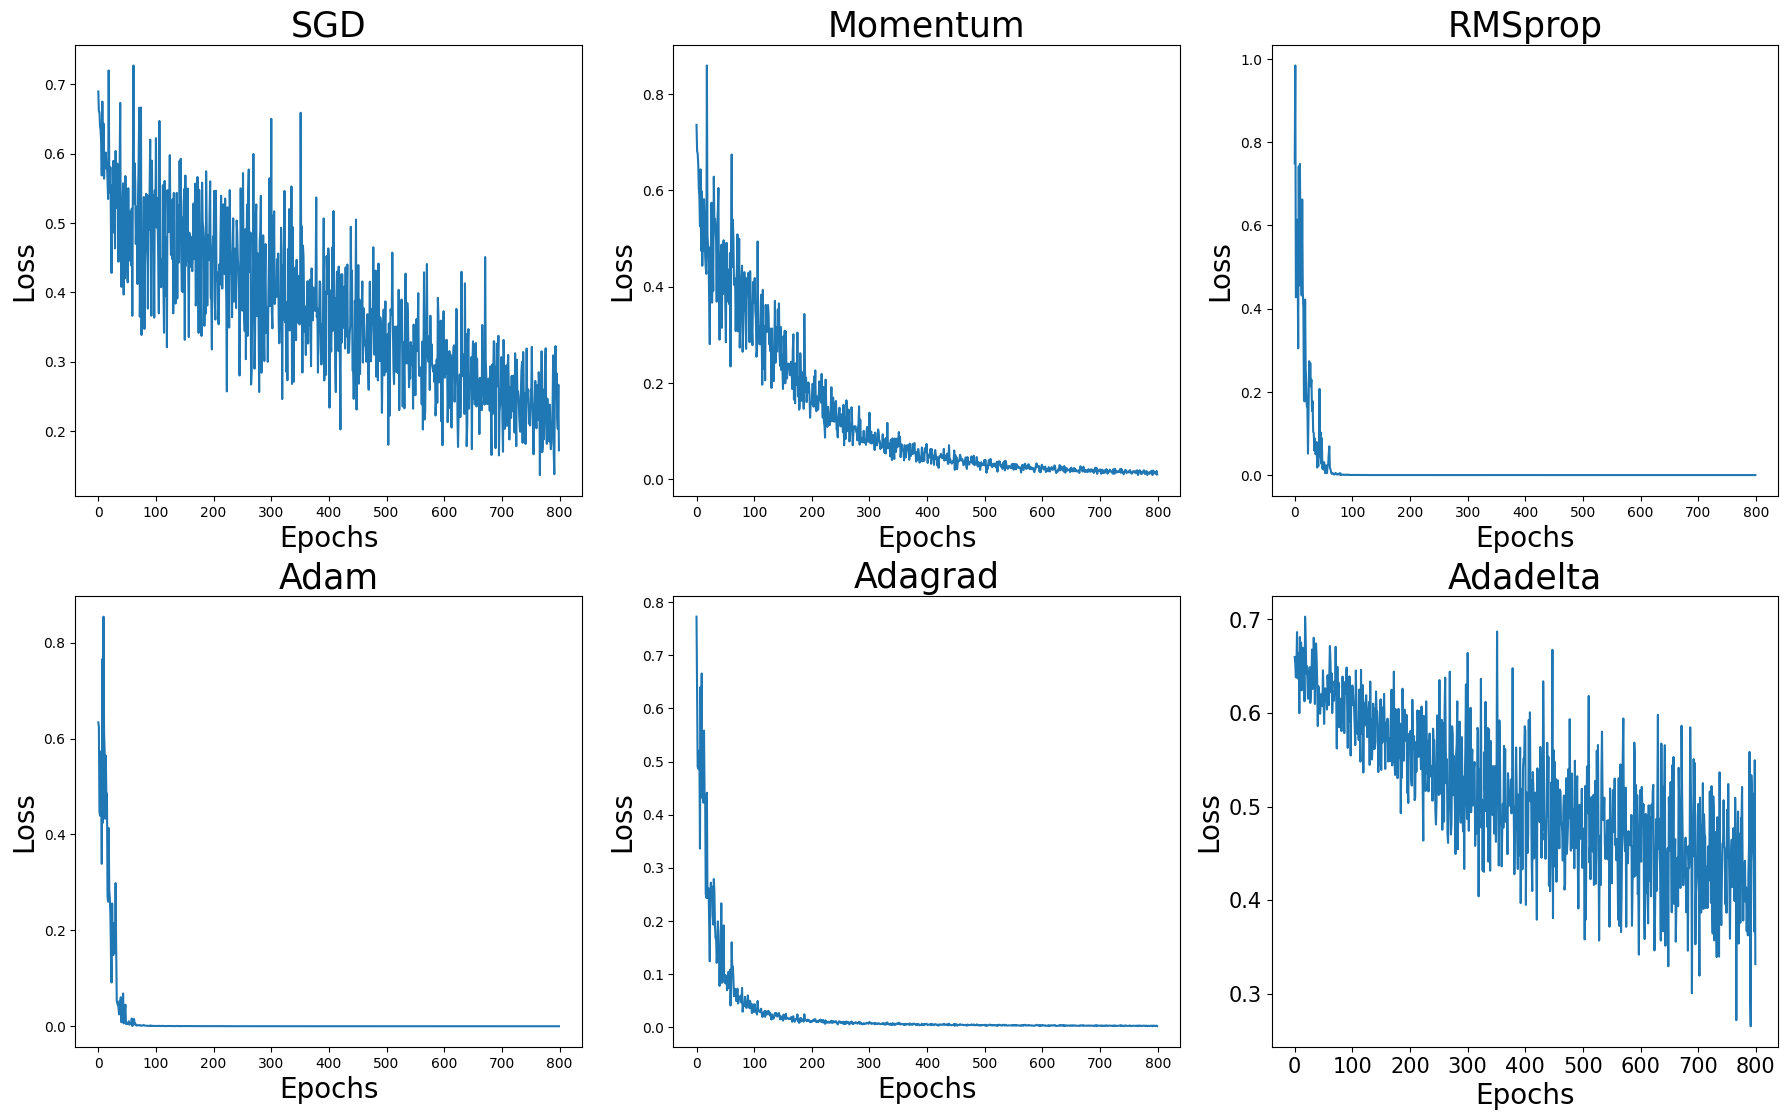

In [243]:
import matplotlib.pyplot as plt

labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (optimizer, loss_history, ax) in enumerate(zip(optimzers, losses_his, axes.flatten())):
    ax.plot(loss_history)
    ax.set_title(labels[i], fontsize = 25)
    ax.set_xlabel('Epochs', fontsize = 20)
    ax.set_ylabel('Loss', fontsize = 20)
    ax.legend()

for ax in axes.flatten():
    ax.legend().set_visible(False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Adam

In [244]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 5, 1):
    i = i / 20
    model = keras.Sequential()
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    #model.add(layers.Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)

    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(min(len(weights), len(lambda_array))):
        for n in range(min(len(weights[j]), len(lambda_array[j]))):
            if abs(weights[j][n]) < 5e-3 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.   0.   0.05 ... 0.1  0.1  0.  ]
 [0.15 0.15 0.05 ... 0.1  0.05 0.05]
 [0.1  0.1  0.05 ... 0.05 0.1  0.05]
 ...
 [0.05 0.1  0.05 ... 0.1  0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.05 0.05]
 [0.05 0.05 0.05 ... 0.05 0.1  0.05]]


In [245]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 1.2890769741329312e-22
绝对值最大权重值: 0.02921026200056076


In [246]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.2


### one-layer

In [247]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i)
t1 = min(T)
t1

0 4 0.0
0 7 0.0
21 33 0.6363636363636364
0 6 0.0
0 1 0.0
30 46 0.6521739130434783
15 23 0.6521739130434783
7 13 0.5384615384615384
3 9 0.3333333333333333
34 55 0.6181818181818182
25 34 0.7352941176470589
0 8 0.0
15 20 0.75
0 2 0.0
10 15 0.6666666666666666
11 17 0.6470588235294118
0 3 0.0
0 5 0.0
17 25 0.68
1 8 0.125
35 61 0.5737704918032787
11 16 0.6875
29 40 0.725
30 46 0.6521739130434783
35 61 0.5737704918032787
9 15 0.6
17 24 0.7083333333333334
12 18 0.6666666666666666
35 59 0.5932203389830508
18 29 0.6206896551724138
20 31 0.6451612903225806
33 51 0.6470588235294118
5 11 0.45454545454545453
35 57 0.6140350877192983
32 48 0.6666666666666666
5 12 0.4166666666666667
2 8 0.25
29 41 0.7073170731707317
16 23 0.6956521739130435
18 29 0.6206896551724138
30 46 0.6521739130434783
4 10 0.4
4 10 0.4
23 34 0.6764705882352942
34 54 0.6296296296296297
32 48 0.6666666666666666
29 40 0.725
38 61 0.6229508196721312
34 56 0.6071428571428571
24 34 0.7058823529411765
13 18 0.7222222222222222
31 46 0.67

0.007835

### Multiple-layer

In [248]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 2, 4, 5, 12, 14, 17, 18], array([439.39716], dtype=float32))

## Adagrad

In [265]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 5, 1):
    i = i / 20
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 0.005 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.   0.1  0.   ... 0.   0.   0.  ]
 [0.   0.   0.2  ... 0.   0.   0.  ]
 [0.   0.   0.2  ... 0.   0.   0.1 ]
 ...
 [0.   0.   0.15 ... 0.   0.1  0.1 ]
 [0.2  0.   0.   ... 0.   0.2  0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]


In [266]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 6.802661118854303e-07
绝对值最大权重值: 0.07642433792352676


In [267]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.2


### one-layer

In [268]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i)
t1 = min(T)
t1

27 15 1.8
17 11 1.5454545454545454
4 4 1.0
14 8 1.75
3 2 1.5
48 28 1.7142857142857142
25 13 1.9230769230769231
3 2 1.5
20 13 1.5384615384615385
51 32 1.59375
50 31 1.6129032258064515
32 15 2.1333333333333333
17 11 1.5454545454545454
0 1 0.0
53 36 1.4722222222222223
57 43 1.3255813953488371
1 1 1.0
39 21 1.8571428571428572
39 21 1.8571428571428572
57 41 1.3902439024390243
29 15 1.9333333333333333
56 40 1.4
46 27 1.7037037037037037
47 28 1.6785714285714286
13 7 1.8571428571428572
38 20 1.9
26 14 1.8571428571428572
40 22 1.8181818181818181
15 8 1.875
19 11 1.7272727272727273
47 28 1.6785714285714286
45 24 1.875
38 19 2.0
20 12 1.6666666666666667
14 8 1.75
57 42 1.3571428571428572
6 4 1.5
43 23 1.8695652173913044
33 15 2.2
8 5 1.6
18 11 1.6363636363636365
56 39 1.435897435897436
49 30 1.6333333333333333
52 36 1.4444444444444444
46 26 1.7692307692307692
17 10 1.7
12 7 1.7142857142857142
5 4 1.25
0 1 0.0
26 14 1.8571428571428572
51 36 1.4166666666666667
7 4 1.75
56 38 1.4736842105263157
37 1

0.1028

### Multiple-layer

In [269]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([9, 14, 18], array([12079.056], dtype=float32))

## RMSprop

In [274]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 5, 1):
    i = i / 20
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-3 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.15 0.05 0.05 ... 0.1  0.1  0.1 ]
 [0.15 0.05 0.05 ... 0.05 0.1  0.1 ]
 [0.15 0.05 0.05 ... 0.05 0.1  0.1 ]
 ...
 [0.15 0.05 0.05 ... 0.1  0.1  0.1 ]
 [0.15 0.05 0.05 ... 0.1  0.1  0.1 ]
 [0.15 0.05 0.05 ... 0.1  0.1  0.1 ]]


In [275]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.2


In [276]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 4.9768348103144484e-39
绝对值最大权重值: 0.03663437068462372


### one-layer

In [277]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

0 3 0.0
4 6 0.6666666666666666
12 17 0.7058823529411765
0 5 0.0
0 1 0.0
5 11 0.45454545454545453
18 24 0.75
14 20 0.7
13 19 0.6842105263157895
47 52 0.9038461538461539
40 46 0.8695652173913043
19 27 0.7037037037037037
19 26 0.7307692307692307
0 4 0.0
17 24 0.7083333333333334
34 39 0.8717948717948718
0 2 0.0
0 5 0.0
14 21 0.6666666666666666
1 5 0.2
45 50 0.9
14 21 0.6666666666666666
38 40 0.95
10 15 0.6666666666666666
16 24 0.6666666666666666
5 13 0.38461538461538464
33 38 0.868421052631579
11 16 0.6875
22 31 0.7096774193548387
39 45 0.8666666666666667
29 37 0.7837837837837838
39 44 0.8863636363636364
5 12 0.4166666666666667
45 50 0.9
42 49 0.8571428571428571
19 25 0.76
2 5 0.4
36 39 0.9230769230769231
13 19 0.6842105263157895
4 9 0.4444444444444444
38 40 0.95
16 24 0.6666666666666666
4 8 0.5
23 32 0.71875
20 29 0.6896551724137931
39 42 0.9285714285714286
20 29 0.6896551724137931
39 41 0.9512195121951219
46 51 0.9019607843137255
42 49 0.8571428571428571
5 10 0.5
41 47 0.8723404255319149

0.013

### Multiple-layer

In [279]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 20, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 4, 5, 14, 17, 18], array([4903.3647], dtype=float32))

## Momentum

In [280]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 5, 1):
    i = i / 20
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-2 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.1  0.1  0.15 ... 0.2  0.15 0.1 ]
 [0.1  0.1  0.15 ... 0.1  0.15 0.15]
 [0.1  0.15 0.15 ... 0.2  0.15 0.1 ]
 ...
 [0.05 0.05 0.05 ... 0.15 0.05 0.1 ]
 [0.15 0.2  0.15 ... 0.2  0.1  0.05]
 [0.15 0.15 0.15 ... 0.15 0.1  0.1 ]]


In [281]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.2


In [282]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 3.563468453648966e-08
绝对值最大权重值: 0.028580598533153534


### one-layer

In [283]:
lambda_array = np.where(lambda_array == 0, 100, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

0 4 0.0
20 27 0.7407407407407407
52 37 1.4054054054054055
0 8 0.0
0 1 0.0
21 28 0.75
10 16 0.625
52 37 1.4054054054054055
2 8 0.25
8 15 0.5333333333333333
23 28 0.8214285714285714
0 6 0.0
55 41 1.3414634146341464
0 2 0.0
49 36 1.3611111111111112
9 16 0.5625
0 3 0.0
0 5 0.0
8 15 0.5333333333333333
1 8 0.125
19 24 0.7916666666666666
0 7 0.0
48 35 1.3714285714285714
37 33 1.121212121212121
55 43 1.2790697674418605
34 33 1.0303030303030303
12 22 0.5454545454545454
20 27 0.7407407407407407
9 16 0.5625
28 31 0.9032258064516129
12 22 0.5454545454545454
11 21 0.5238095238095238
6 11 0.5454545454545454
54 38 1.4210526315789473
55 43 1.2790697674418605
3 9 0.3333333333333333
12 22 0.5454545454545454
12 22 0.5454545454545454
49 36 1.3611111111111112
33 32 1.03125
12 22 0.5454545454545454
5 10 0.5
26 30 0.8666666666666667
32 31 1.032258064516129
37 33 1.121212121212121
29 31 0.9354838709677419
11 21 0.5238095238095238
46 34 1.3529411764705883
23 28 0.8214285714285714
19 24 0.7916666666666666
8 13 

0.023020000000000006

### Multiple-layer

In [284]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 20, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 4, 5, 12, 14, 17, 18, 22], array([492.1553], dtype=float32))

## VWA Filter

In [67]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow.keras as keras
from tensorflow.keras import layers

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

num_variables = X.shape[1]
running_times = []
accuracies = []

for x_index in range(num_variables):
    current_x = X[:, x_index].reshape(-1, 1)

    input_dim = 1
    acc = []

    for i in range(10):
        model = keras.Sequential()
        model.add(layers.Dense(264, input_shape=(input_dim,)))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        model.fit(current_x, y, epochs=50, batch_size=32, verbose=0)
        predictions = model.predict(current_x)
        predicted = (predictions > 0.5)
        accuracy = accuracy_score(y, predicted)
        end_time = time.time()
        run_time = end_time - start_time

        acc.append(accuracy)

    avg_accuracy = np.mean(acc)
    
    accuracies.append(avg_accuracy)

print("Accuracies for each variable:", accuracies)


16/16 [==============================] - 0s 1ms/step
Accuracies for each variable: [0.7828, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.783, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7916000000000001, 0.7859999999999999, 0.7859999999999999, 0.7867999999999999, 0.7868, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.78599999999

### one layer

In [12]:
from collections import defaultdict

accuracies = [0.7828, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.783, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7916000000000001, 0.7859999999999999, 0.7859999999999999, 0.7867999999999999, 0.7868, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999, 0.7859999999999999]
lists = [
    [1,2,4,5,12,14,17,18],
    [14],
    [1,4,5,14,17],
    [1,4,5,12,14,17,18,22]
]
import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")

Selected Variables: [1, 4, 5, 12, 14, 17, 18]
Variable weights sorted:


### Multiple layers

In [13]:
from collections import defaultdict

lists = [
    [1, 2, 4, 5, 12, 14, 17, 18],
    [9, 14, 18],
    [1, 4, 5, 14, 17, 18],
    [1, 4, 5, 12, 14, 17, 18, 22]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")

Selected Variables: [1, 4, 5, 12, 14, 17, 18]
Variable weights sorted:


### one layer and multiple layers

In [14]:
from collections import defaultdict

lists = [
    [1,2,4,5,12,14,17,18],
    [1, 2, 4, 5, 12, 14, 17, 18],
    [14],
    [9, 14, 18],
    [1,4,5,14,17],
    [1, 4, 5, 14, 17, 18],
    [1,4,5,12,14,17,18,22],
    [1, 4, 5, 12, 14, 17, 18, 22]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")

Selected Variables: [1, 2, 4, 5, 12, 14, 17, 18, 22]
Variable weights sorted:


# 100 features(10 related)

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    W1 = np.random.normal(loc=0, scale=1, size=(input_size, hidden_size))
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.normal(loc=0, scale=1, size=(hidden_size, output_size))
    b2 = np.zeros((1, output_size))
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

def forward_propagation(X, parameters):
    Z1 = np.dot(X, parameters['W1']) + parameters['b1']
    A1 = relu(Z1)
    Z2 = np.dot(A1, parameters['W2']) + parameters['b2']
    A2 = sigmoid(Z2)
    return {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}

def predict(X, parameters):
    forward = forward_propagation(X, parameters)
    return (forward['A2'] > 0.5).astype(int)

# Set up neural network parameters
input_size = 100
hidden_size = 264
output_size = 1

# Generate random input data
np.random.seed(42)
n_samples = 500

# Generate the first 10 variables using the neural network
X_first_10 = np.random.normal(loc=0, scale=1, size=(n_samples, 10))
parameters = initialize_parameters(10, hidden_size, output_size)
forward = forward_propagation(X_first_10, parameters)
y_neural_network = forward['A2']

# Generate random values for the remaining variables
X_rest = np.random.normal(loc=0, scale=1, size=(n_samples, input_size - 10))

# Combine the generated values
X = np.concatenate((X_first_10, X_rest), axis=1)

# Threshold for binary classification
threshold = 0.5
y_binary_neural_network = (y_neural_network > threshold).astype(int)

# Add the generated y values to the existing DataFrame
data = pd.DataFrame(X, columns=[f'var{i}' for i in range(input_size)])
data['y'] = y_binary_neural_network

# Print the DataFrame
print(data.head())

       var0      var1      var2      var3      var4      var5      var6  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1 -0.463418 -0.465730  0.241962 -1.913280 -1.724918 -0.562288 -1.012831   
2  1.465649 -0.225776  0.067528 -1.424748 -0.544383  0.110923 -1.150994   
3 -0.601707  1.852278 -0.013497 -1.057711  0.822545 -1.220844  0.208864   
4  0.738467  0.171368 -0.115648 -0.301104 -1.478522 -0.719844 -0.460639   

       var7      var8      var9  ...     var91     var92     var93     var94  \
0  0.767435 -0.469474  0.542560  ... -0.960046 -0.122709  0.093372 -1.130204   
1  0.314247 -0.908024 -1.412304  ...  1.818062  0.775155  0.553040  0.234024   
2  0.375698 -0.600639 -0.291694  ... -1.751829 -0.389924  0.158053 -0.096624   
3 -1.959670 -1.328186  0.196861  ...  0.148089 -0.881068 -0.712221  1.186735   
4  1.057122  0.343618 -1.763040  ...  1.628469 -0.284385  1.590582  0.678931   

      var95     var96     var97     var98     var99  y  
0  2.411677

In [69]:
import numpy as np
from scipy.sparse.linalg import eigsh

## some useful functions
def get_arccos(X):
    # X is a 2-d array
    n, p = X.shape
    cos_a = np.zeros([n, n, n])
    
    for r in range(n):
        
        xr = X[r]
        X_r = X - xr
        cross = np.dot(X_r, X_r.T)
        row_norm = np.sqrt(np.sum(X_r**2, axis = 1))
        outer_norm = np.outer(row_norm, row_norm)
        
        zero_idx = (outer_norm == 0.)
        outer_norm[zero_idx] = 1.
        cos_a_kl = cross / outer_norm
        cos_a_kl[zero_idx] = 0.

        cos_a[:,:,r] = cos_a_kl
        
    cos_a[cos_a > 1] = 1.
    cos_a[cos_a < -1] = -1.
    a = np.arccos(cos_a)

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
        
    return a, A

def get_arccos_1d(X):
    # X is a 1-d array
    
    X = np.squeeze(X)
    Y = X[:,None] - X
    Z = Y.T[:,:,None]*Y.T[:,None]
    n = len(X)
    
    a = np.zeros([n, n, n])
    a[Z == 0.] = np.pi/2.
    a[Z < 0.] = np.pi
    
    a = np.transpose(a, (1,2,0))
    
    #a = Z[Z>0.]*0. + Z[Z==0.]*np.pi/2. + Z[Z<0.]*np.pi

    a_bar_12 = np.mean(a, axis = 0, keepdims = True)
    a_bar_02 = np.mean(a, axis = 1, keepdims = True)
    a_bar_2  = np.mean(a, axis = (0,1), keepdims = True)
    A = a - a_bar_12 - a_bar_02 + a_bar_2
    
    return a, A

def orthonormalize(X):
    # X is a 2-d array
    # output: Gram-Schmidt orthogonalization of X
    
    n, p = X.shape
    Y = np.zeros([n,p])
    Y[:,0] = X[:,0]/np.sqrt(np.sum(X[:,0]**2))
    
    for j in range(1,p):
        
        Yj = Y[:,range(j)]
        xj = X[:,j]
        w = np.dot(xj, Yj)
        xj_p = np.sum(w*Yj, axis = 1)
        yj = xj - xj_p
        yj = yj/np.sqrt(np.sum(yj**2))
        
        Y[:,j] = yj
        
    return Y

# Main functions
def projection_corr(X, Y):
    # X, Y are 2-d array
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1d(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos_1d(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def projection_corr_1dy(X, Y):
    
    nx, p = X.shape
    ny, q = Y.shape
    
    if nx == ny:
        n = nx
    else:
        raise ValueError("sample sizes do not match.")
        
    a_x, A_x = get_arccos(X)
    a_y, A_y = get_arccos_1d(Y)
    
    S_xy = np.sum(A_x * A_y) / (n**3)
    S_xx = np.sum(A_x**2) / (n**3)
    S_yy = np.sum(A_y**2) / (n**3)
    
    if S_xx * S_yy == 0.:
        corr = 0.
    else:
        corr = np.sqrt( S_xy / np.sqrt(S_xx * S_yy) )
    
    return corr

def get_equi_features(X):
    # X is 2-d array
    
    n, p = X.shape
    scale = np.sqrt(np.sum(X**2, axis=0))
    Xstd = X / scale
    sigma = np.dot(Xstd.T, Xstd)
    sigma_inv = np.linalg.inv(sigma)
    lambd_min = eigsh(sigma, k=1, which='SA')[0].squeeze()
    sj = np.min([1., 2.*lambd_min])
    sj = sj - 0.00001
    
    mat_s = np.diag([sj]*p)
    A = 2*mat_s - sj*sj*sigma_inv
    C = np.linalg.cholesky(A).T
    
    Xn = np.random.randn(n, p)
    XX = np.hstack([Xstd, Xn])
    XXo = orthonormalize(XX)
    U = XXo[:,range(p,2*p)]
    
    Xnew = np.dot(Xstd,  np.eye(p) - sigma_inv*sj) + np.dot(U,C)
    return Xnew

In [70]:
X = data.iloc[:,:-1]
X = (X - X.mean()) / X.std()
Y = data.iloc[:,-1]
X_knockoff = get_equi_features(X)
X_knockoff = (X_knockoff - X_knockoff.mean()) / X_knockoff.std()

In [71]:
X_knockoff_df = pd.DataFrame(X_knockoff)
column_names = ['feature0_k', 'feature1_k', 'feature2_k', 'feature3_k', 'feature4_k','feature5_k', 'feature6_k', 'feature7_k', 'feature8_k', 'feature9_k',
                'feature10_k', 'feature11_k', 'feature12_k', 'feature13_k', 'feature14_k','feature15_k', 'feature16_k', 'feature17_k', 'feature18_k', 'feature19_k',
                'feature20_k', 'feature21_k', 'feature22_k', 'feature23_k', 'feature24_k','feature25_k', 'feature26_k', 'feature27_k', 'feature28_k', 'feature29_k',
                'feature30_k', 'feature31_k', 'feature32_k', 'feature33_k', 'feature34_k','feature35_k', 'feature36_k', 'feature37_k', 'feature38_k', 'feature39_k',
                'feature40_k', 'feature41_k', 'feature42_k', 'feature43_k', 'feature44_k','feature45_k', 'feature46_k', 'feature47_k', 'feature48_k', 'feature49_k',
                'feature50_k', 'feature51_k', 'feature52_k', 'feature53_k', 'feature54_k','feature55_k', 'feature56_k', 'feature57_k', 'feature58_k', 'feature59_k',
                'feature60_k', 'feature61_k', 'feature62_k', 'feature63_k', 'feature64_k','feature65_k', 'feature66_k', 'feature67_k', 'feature68_k', 'feature69_k',
                'feature70_k', 'feature71_k', 'feature72_k', 'feature73_k', 'feature74_k','feature75_k', 'feature76_k', 'feature77_k', 'feature78_k', 'feature79_k',
                'feature80_k', 'feature81_k', 'feature82_k', 'feature83_k', 'feature84_k','feature85_k', 'feature86_k', 'feature87_k', 'feature88_k', 'feature89_k',
                'feature90_k', 'feature91_k', 'feature92_k', 'feature93_k', 'feature94_k','feature95_k', 'feature96_k', 'feature97_k', 'feature98_k', 'feature99_k']
X_knockoff_df.columns = column_names
feature = pd.concat([X,X_knockoff_df],axis = 1)
feature.to_csv('data_feature.csv', index=False)
Y.to_csv('data_Y.csv', index=False)
feature

,var0,var1,var2,var3,var4,var5,var6,var7,var8,var9,...,feature90_k,feature91_k,feature92_k,feature93_k,feature94_k,feature95_k,feature96_k,feature97_k,feature98_k,feature99_k
0,0.516050,-0.149242,0.637489,1.586617,-0.223665,-0.224346,1.640890,0.760685,-0.549253,0.490815,...,-0.843230,-1.757559,0.027645,0.042979,-1.205581,-0.536259,1.517510,-1.047886,-0.090478,1.056054
1,-0.487810,-0.457749,0.235009,-1.917944,-1.688289,-0.539512,-0.962441,0.309114,-1.016768,-1.549008,...,-0.500013,0.211798,1.339089,-0.250295,1.197001,0.673673,0.981844,0.444820,0.655091,-0.759562
2,1.529114,-0.231688,0.061970,-1.419709,-0.528454,0.107061,-1.101205,0.370345,-0.689081,-0.379696,...,-2.792355,1.144986,-0.165385,1.812058,0.143784,-2.745885,0.093119,2.459094,-0.627213,0.555493
3,-0.632397,1.726058,-0.018407,-1.045381,0.814504,-1.172010,0.264573,-1.956695,-1.464681,0.130092,...,-0.562663,-0.805913,-0.364884,-0.200754,0.059667,0.012873,0.200512,-0.977635,1.217314,-0.564284
4,0.768813,0.142464,-0.119741,-0.273747,-1.446213,-0.690834,-0.407844,1.049339,0.317542,-1.914988,...,-0.552584,0.933917,-0.165863,1.252376,-0.448334,-0.034521,0.787903,-0.231562,0.160144,-0.861617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.247860,1.161600,0.778582,1.022164,0.327507,-1.333800,-0.141750,1.052296,-0.103697,0.449630,...,1.923050,0.027977,0.924675,0.504852,-1.819657,2.293779,2.062026,2.540348,-0.929209,-0.221650
496,-0.336551,-0.989174,-0.127375,0.348523,-0.637808,-0.225858,-0.888754,1.111241,-0.362675,1.440568,...,-1.439295,-0.321969,0.138574,0.245598,-0.494778,1.121171,-0.882284,-0.175357,1.748237,-0.146317
497,1.595087,-0.095336,-1.005399,-2.093990,-1.439842,-1.318948,1.439272,0.111398,0.366566,-2.392247,...,0.439863,-2.707189,-1.335287,-1.774740,-2.133792,-0.381136,-0.615535,1.113304,0.492491,0.107804
498,-1.255813,0.816740,0.279462,-0.116792,0.561321,1.571599,-0.167205,0.065109,0.156546,2.420747,...,1.237597,0.180237,0.134587,-0.426625,-0.063340,-1.721581,-0.257451,1.819809,-1.758666,0.670085


## Optimizers Selction

In [23]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# 超参数
LR = 0.01
BATCH_SIZE = 64
EPOCH = 50

# 神经网络定义
class Net(nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden)
        self.output = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.output(x)
        return torch.sigmoid(x)

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

feature1 = np.array(feature)
feature1 = torch.Tensor(feature1)

y1 = torch.Tensor(Y)
y1 = y1.view(-1, 1)

torch_dataset = TensorDataset(feature1, y1)
loader = DataLoader(dataset=torch_dataset, batch_size=32, shuffle=True)

net_SGD = Net(200, 264, 1)
net_Momentum = Net(200, 264, 1)
net_RMSprop = Net(200, 264, 1)
net_Adam = Net(200, 264, 1)
net_Adagrad = Net(200, 264, 1)
net_Adadelta = Net(200, 264, 1)

In [291]:
nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam, net_Adagrad, net_Adadelta]

optimizer_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
optimizer_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
optimizer_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
optimizer_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizer_Adagrad = torch.optim.Adagrad(net_Adagrad.parameters(), lr=LR)
optimizer_Adadelta = torch.optim.Adadelta(net_Adadelta.parameters(), lr=LR, rho=0.9, eps=1e-06)

optimzers = [optimizer_SGD, optimizer_Momentum, optimizer_RMSprop, optimizer_Adam, optimizer_Adagrad, optimizer_Adadelta]
losses_his = [[] for _ in range(len(optimzers))]

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


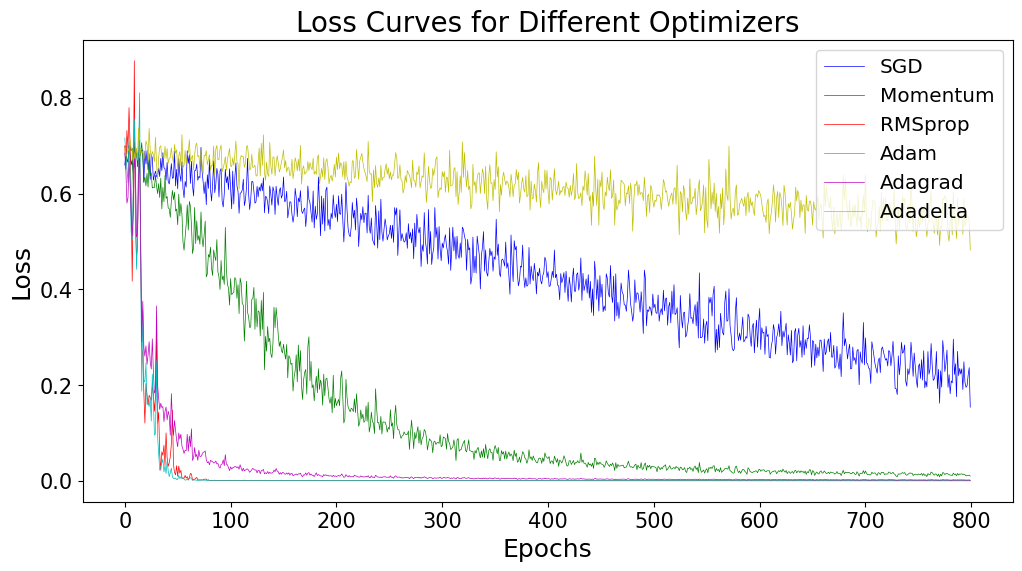

In [292]:
loss_func = nn.BCELoss()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']
for epoch in range(EPOCH):
    print(f'Epoch {epoch + 1}/{EPOCH}')
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, optimizer, loss_his in zip(nets, optimzers, losses_his):
            net_output = net(batch_x)
            loss = loss_func(net_output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_his.append(loss.item())

plt.figure(figsize=(12, 6))
for i, optimizer in enumerate(optimzers):
    plt.plot(losses_his[i],label=labels[i], lw=0.5, color=colors[i])
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize='x-large')
plt.title('Loss Curves for Different Optimizers', fontsize = 20)
plt.show()

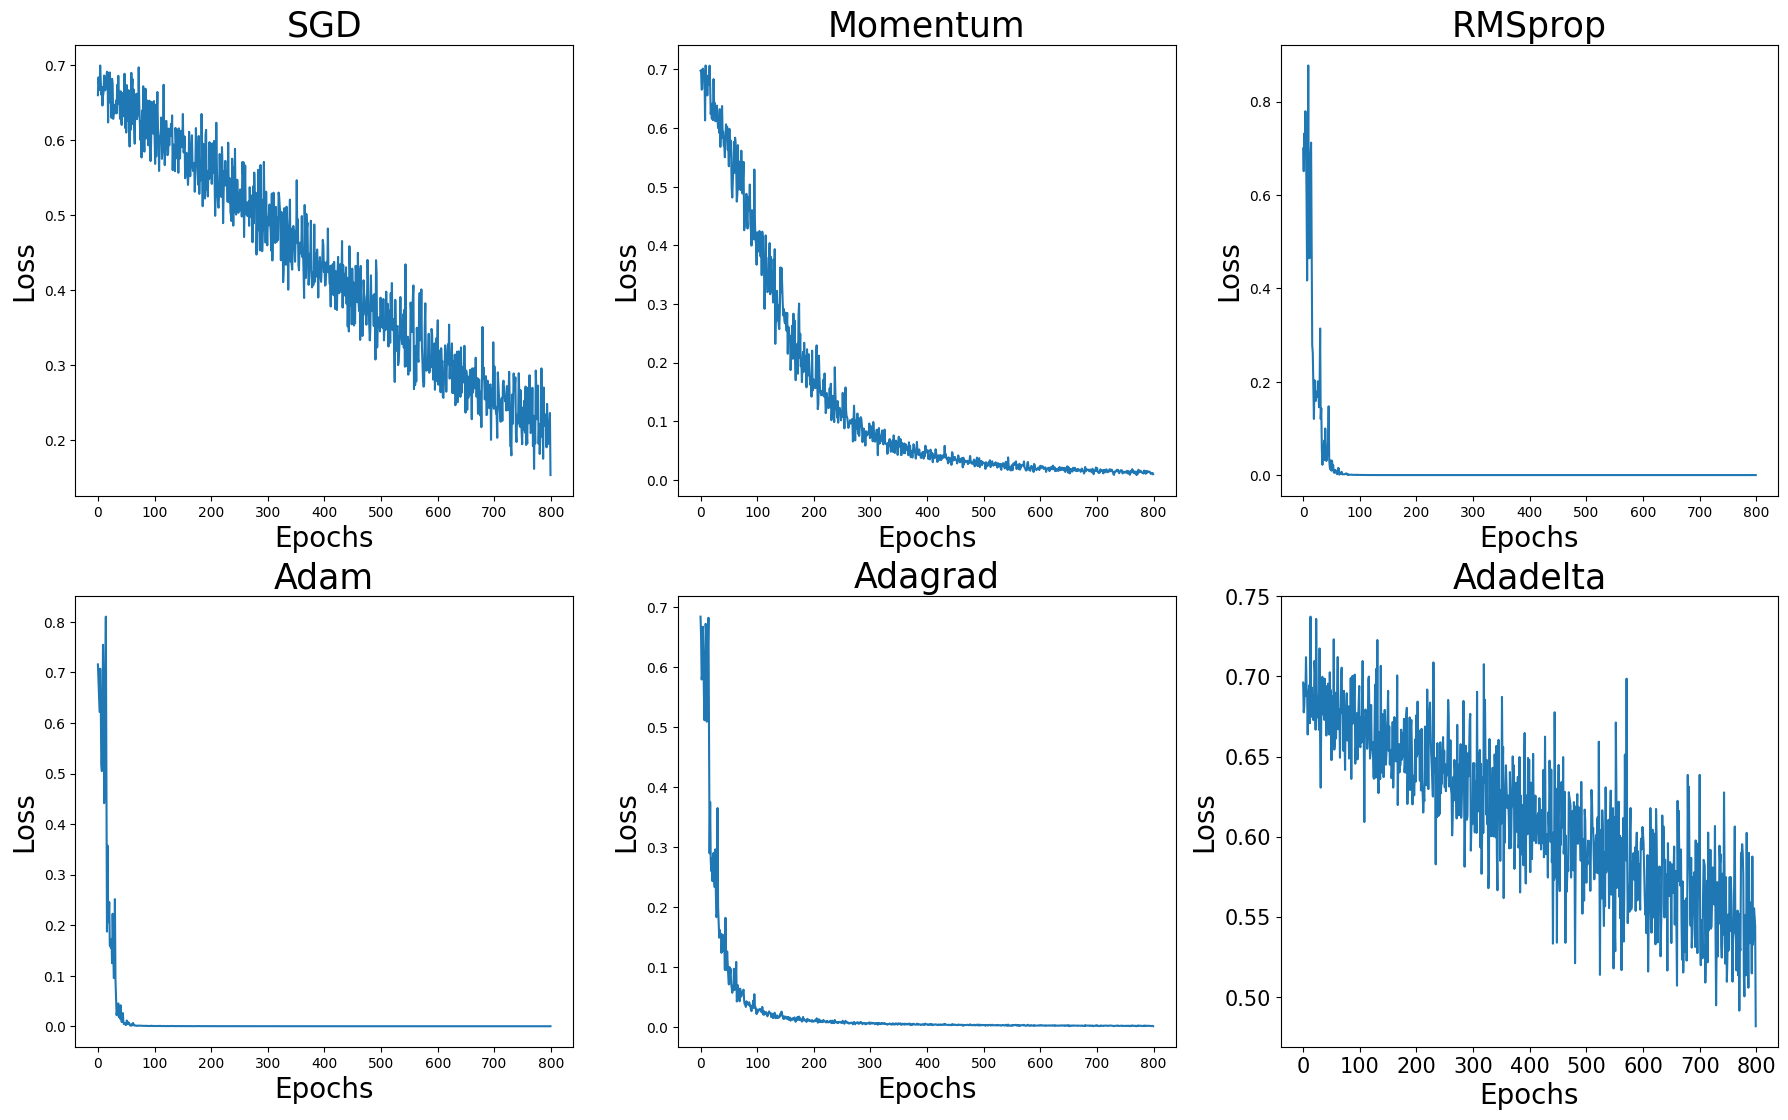

In [293]:
import matplotlib.pyplot as plt

labels = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (optimizer, loss_history, ax) in enumerate(zip(optimzers, losses_his, axes.flatten())):
    ax.plot(loss_history)
    ax.set_title(labels[i], fontsize = 25)
    ax.set_xlabel('Epochs', fontsize = 20)
    ax.set_ylabel('Loss', fontsize = 20)
    ax.legend()

for ax in axes.flatten():
    ax.legend().set_visible(False)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Adam

In [294]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 5, 1):
    i = i / 20
    model = keras.Sequential()
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    #model.add(layers.Dense(200, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)

    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(min(len(weights), len(lambda_array))):
        for n in range(min(len(weights[j]), len(lambda_array[j]))):
            if abs(weights[j][n]) < 5e-4 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.   0.1  0.1  ... 0.2  0.2  0.  ]
 [0.   0.1  0.1  ... 0.2  0.2  0.  ]
 [0.2  0.1  0.1  ... 0.2  0.   0.2 ]
 ...
 [0.15 0.1  0.1  ... 0.2  0.1  0.1 ]
 [0.   0.1  0.1  ... 0.15 0.2  0.2 ]
 [0.05 0.15 0.1  ... 0.   0.2  0.2 ]]


In [295]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 9.830627989886457e-21
绝对值最大权重值: 0.04450283199548721


In [296]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.2


### one-layer

In [297]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.1:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

1 7 0.14285714285714285
0 5 0.0
32 32 1.0
22 30 0.7333333333333333
0 6 0.0
1 8 0.125
0 1 0.0
0 2 0.0
0 3 0.0
0 4 0.0
22 30 0.7333333333333333
15 25 0.6
33 33 1.0
9 18 0.5
1 8 0.125
46 39 1.1794871794871795
41 37 1.1081081081081081
32 32 1.0
6 11 0.5454545454545454
26 30 0.8666666666666667
39 36 1.0833333333333333
50 44 1.1363636363636365
14 22 0.6363636363636364
31 31 1.0
8 18 0.4444444444444444
8 18 0.4444444444444444
9 18 0.5
20 28 0.7142857142857143
3 10 0.3
52 46 1.1304347826086956
15 26 0.5769230769230769
15 26 0.5769230769230769
6 13 0.46153846153846156
22 29 0.7586206896551724
2 10 0.2
2 9 0.2222222222222222
27 30 0.9
49 43 1.1395348837209303
20 28 0.7142857142857143
21 28 0.75
39 35 1.1142857142857143
45 37 1.2162162162162162
49 44 1.1136363636363635
35 34 1.0294117647058822
11 18 0.6111111111111112
38 34 1.1176470588235294
53 46 1.1521739130434783
29 31 0.9354838709677419
5 10 0.5
17 27 0.6296296296296297
2 10 0.2
46 38 1.2105263157894737
13 21 0.6190476190476191
16 27 0.59259

0.065045

### Multiple-layer

In [298]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 2, 5, 6, 7, 8, 9, 10], array([48566.645], dtype=float32))

## Adagrad

In [324]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 3, 1):
    i = i / 20
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-5 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [325]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 1.555261405883357e-06
绝对值最大权重值: 0.09021652489900589


In [326]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.1


### one-layer

In [327]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
0 96 0.0
Variable is select:  1
Variable is select:  2
Variable is select:  3
Variable is select:  4
Variable

0.132

### Multiple-layer

In [328]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([7, 8], array([57962.363], dtype=float32))

## RMSprop

In [334]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 3, 1):
    i = i / 20
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-3 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.   0.   0.1  ... 0.05 0.   0.05]
 [0.   0.   0.   ... 0.05 0.   0.05]
 [0.   0.   0.   ... 0.05 0.1  0.05]
 ...
 [0.   0.   0.   ... 0.05 0.   0.05]
 [0.   0.1  0.   ... 0.05 0.   0.05]
 [0.1  0.   0.   ... 0.05 0.   0.05]]


In [335]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 2.1603762372557132e-38
绝对值最大权重值: 0.04325461760163307


In [336]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.1


### one-layer

In [337]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

0 8 0.0
0 6 0.0
34 40 0.85
8 17 0.47058823529411764
0 7 0.0
0 2 0.0
0 1 0.0
0 3 0.0
0 4 0.0
0 5 0.0
22 29 0.7586206896551724
5 12 0.4166666666666667
20 27 0.7407407407407407
10 17 0.5882352941176471
4 10 0.4
36 41 0.8780487804878049
27 32 0.84375
22 29 0.7586206896551724
1 9 0.1111111111111111
14 21 0.6666666666666666
39 44 0.8863636363636364
39 45 0.8666666666666667
5 11 0.45454545454545453
47 53 0.8867924528301887
16 22 0.7272727272727273
17 23 0.7391304347826086
32 36 0.8888888888888888
16 23 0.6956521739130435
41 46 0.8913043478260869
41 46 0.8913043478260869
46 51 0.9019607843137255
5 15 0.3333333333333333
11 18 0.6111111111111112
33 37 0.8918918918918919
3 9 0.3333333333333333
19 27 0.7037037037037037
42 46 0.9130434782608695
18 24 0.75
14 21 0.6666666666666666
26 32 0.8125
23 29 0.7931034482758621
26 32 0.8125
24 29 0.8275862068965517
34 38 0.8947368421052632
43 47 0.9148936170212766
39 43 0.9069767441860465
46 52 0.8846153846153846
26 31 0.8387096774193549
2 9 0.222222222222222

0.065045

### Multiple-layer

In [338]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 2, 5, 6, 7, 8, 9, 10, 94], array([158702.86], dtype=float32))

## Momentum

In [344]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lambda_array = np.zeros((200,264))
input_dim = 200
for i in range(0, 3, 1):
    i = i / 20
    model = keras.Sequential()
    #model.add(layers.Dense(60, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i), input_shape=(input_dim,)))
    model.add(layers.Dense(264, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(i)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(feature, Y, epochs=50, batch_size=32, verbose=0)
    
    # 获取第一层的权重
    first_layer = model.layers[0]
    weights, biases = first_layer.get_weights()
    #print(weights)
    for j in range(len(weights)):
        for n in range(len(weights[j])):
            if abs(weights[j][n]) < 1e-2 and lambda_array[j][n]==0:
                lambda_array[j][n] = i

print(lambda_array)

[[0.1  0.1  0.1  ... 0.1  0.05 0.1 ]
 [0.1  0.1  0.   ... 0.   0.   0.  ]
 [0.   0.1  0.1  ... 0.1  0.1  0.1 ]
 ...
 [0.   0.   0.05 ... 0.05 0.05 0.1 ]
 [0.   0.1  0.1  ... 0.   0.1  0.  ]
 [0.   0.   0.05 ... 0.1  0.   0.  ]]


In [345]:
min_weights = np.min(abs(weights))
max_weights = np.max(abs(weights))

print(f"绝对值最小权重值: {min_weights}")
print(f"绝对值最大权重值: {max_weights}")

绝对值最小权重值: 1.1784995876951143e-06
绝对值最大权重值: 0.07244959473609924


In [346]:
min_lambda = np.min(abs(lambda_array))
max_lambda = np.max(abs(lambda_array))

print(f"绝对值最小lambda值: {min_lambda}")
print(f"绝对值最大lambda值: {max_lambda}")

绝对值最小lambda值: 0.0
绝对值最大lambda值: 0.1


### one-layer

In [347]:
lambda_array = np.where(lambda_array == 0, 5, lambda_array)
row_sums = np.sum(lambda_array , axis=1)
row_sums1 = row_sums
W1 = []
for i in range(0,int(0.5*len(row_sums)),1):
    if row_sums[i]>=row_sums[i+100]:
        W1.append(row_sums[i]/10000)
    else:
        W1.append(-row_sums[i+100]/10000)
        
T = []
for i in W1:
    count1 = 0
    count2 = 0
    t = abs(i)
    for j in W1:
        if j < -t:
            count1 = count1+1
        if j >= t:
            count2 = count2 +1
    q = (count1)/(max(count2,1))
    print(count1,count2,q)
    if q <= 0.01:
        T.append(t)
for i in range(len(W1)):
    if W1[i]>=min(T):
        print("Variable is select: ",i+1)
t1 = min(T)
t1

25 33 0.7575757575757576
3 9 0.3333333333333333
21 29 0.7241379310344828
1 2 0.5
3 11 0.2727272727272727
2 7 0.2857142857142857
0 1 0.0
2 6 0.3333333333333333
4 12 0.3333333333333333
4 12 0.3333333333333333
1 4 0.25
23 33 0.696969696969697
3 8 0.375
2 7 0.2857142857142857
10 22 0.45454545454545453
33 41 0.8048780487804879
24 33 0.7272727272727273
31 38 0.8157894736842105
35 48 0.7291666666666666
41 52 0.7884615384615384
32 39 0.8205128205128205
9 21 0.42857142857142855
26 33 0.7878787878787878
19 26 0.7307692307692307
21 30 0.7
15 23 0.6521739130434783
44 53 0.8301886792452831
3 11 0.2727272727272727
12 22 0.5454545454545454
7 21 0.3333333333333333
21 30 0.7
36 50 0.72
29 36 0.8055555555555556
6 16 0.375
10 22 0.45454545454545453
35 47 0.7446808510638298
1 5 0.2
17 24 0.7083333333333334
35 44 0.7954545454545454
31 37 0.8378378378378378
27 34 0.7941176470588235
20 28 0.7142857142857143
20 28 0.7142857142857143
30 36 0.8333333333333334
37 51 0.7254901960784313
6 17 0.35294117647058826
39

0.07246500000000002

### Multiple-layers

In [348]:
def compute_W(model, lambda_array):
    # Get weights of the layers
    weight_list = [layer.get_weights()[0] for layer in model.layers if 'dense' in layer.name]
    
    # Compute the dot product across all layers
    w_m = weight_list[0]
    for weight in weight_list[1:]:
        w_m = np.dot(w_m, weight)
    
    # Adjust lambda_array values
    lambda_array_adj = np.where(lambda_array == 0, 2, lambda_array)
    row_sums = np.sum(lambda_array_adj, axis=1)
    Z = [row_sums[i]*w_m[i] for i in range(len(w_m))]
    W = [Z[i]**2 - Z[i+100]**2 for i in range(int(len(Z)/2))]
    
    return W

def select_variables(W):
    T = []
    for i in W:
        count1 = len([j for j in W if j < -abs(i)])
        count2 = len([j for j in W if j >= abs(i)])
        q = count1 / max(count2, 1)
        if q < 0.01:
            T.append(abs(i))
    
    threshold = min(T)
    selected_vars = [i+1 for i in range(len(W)) if W[i] >= threshold]
    return selected_vars, threshold

# Sample usage:
W = compute_W(model, lambda_array)
selected_vars, threshold_value = select_variables(W)
selected_vars, threshold_value

([1, 2, 5, 6, 7, 8, 9, 10, 33], array([13599.318], dtype=float32))

## VWA Filter

In [72]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow.keras as keras
from tensorflow.keras import layers

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

num_variables = X.shape[1]
running_times = []
accuracies = []

for x_index in range(num_variables):
    current_x = X[:, x_index].reshape(-1, 1)

    input_dim = 1
    acc = []

    for i in range(10):
        model = keras.Sequential()
        model.add(layers.Dense(264, input_shape=(input_dim,)))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        start_time = time.time()
        model.fit(current_x, y, epochs=50, batch_size=32, verbose=0)
        predictions = model.predict(current_x)
        predicted = (predictions > 0.5)
        accuracy = accuracy_score(y, predicted)
        end_time = time.time()
        run_time = end_time - start_time

        acc.append(accuracy)

    avg_accuracy = np.mean(acc)
    
    accuracies.append(avg_accuracy)

print("Accuracies for each variable:", accuracies)

16/16 [==============================] - 0s 2ms/step
Accuracies for each variable: [0.5766, 0.6234, 0.5713999999999999, 0.572, 0.579, 0.5775999999999999, 0.6862, 0.6452000000000001, 0.615, 0.591, 0.572, 0.5746, 0.5704, 0.572, 0.5721999999999999, 0.5687999999999999, 0.572, 0.572, 0.574, 0.572, 0.572, 0.5774000000000001, 0.5717999999999999, 0.572, 0.5714, 0.5723999999999999, 0.572, 0.572, 0.568, 0.572, 0.574, 0.5772, 0.5651999999999999, 0.572, 0.5925999999999999, 0.5702, 0.5767999999999999, 0.5702, 0.5691999999999999, 0.5717999999999999, 0.572, 0.572, 0.5718, 0.572, 0.572, 0.572, 0.5740000000000001, 0.5714, 0.5664, 0.572, 0.572, 0.572, 0.572, 0.572, 0.5740000000000001, 0.572, 0.5726, 0.572, 0.572, 0.572, 0.5718, 0.5704, 0.5731999999999999, 0.5711999999999999, 0.5718, 0.555, 0.572, 0.572, 0.572, 0.5693999999999999, 0.572, 0.572, 0.5724, 0.5711999999999999, 0.5721999999999999, 0.5826, 0.5833999999999999, 0.572, 0.572, 0.5721999999999999, 0.5721999999999999, 0.5716, 0.5683999999999999, 0.57

### one layer

In [18]:
from collections import defaultdict

accuracies = [0.5766, 0.6234, 0.5713999999999999, 0.572, 0.579, 0.5775999999999999, 0.6862, 0.6452000000000001, 0.615, 0.591, 0.572, 0.5746, 0.5704, 0.572, 0.5721999999999999, 0.5687999999999999, 0.572, 0.572, 0.574, 0.572, 0.572, 0.5774000000000001, 0.5717999999999999, 0.572, 0.5714, 0.5723999999999999, 0.572, 0.572, 0.568, 0.572, 0.574, 0.5772, 0.5651999999999999, 0.572, 0.5925999999999999, 0.5702, 0.5767999999999999, 0.5702, 0.5691999999999999, 0.5717999999999999, 0.572, 0.572, 0.5718, 0.572, 0.572, 0.572, 0.5740000000000001, 0.5714, 0.5664, 0.572, 0.572, 0.572, 0.572, 0.572, 0.5740000000000001, 0.572, 0.5726, 0.572, 0.572, 0.572, 0.5718, 0.5704, 0.5731999999999999, 0.5711999999999999, 0.5718, 0.555, 0.572, 0.572, 0.572, 0.5693999999999999, 0.572, 0.572, 0.5724, 0.5711999999999999, 0.5721999999999999, 0.5826, 0.5833999999999999, 0.572, 0.572, 0.5721999999999999, 0.5721999999999999, 0.5716, 0.5683999999999999, 0.572, 0.572, 0.572, 0.572, 0.5718, 0.5691999999999999, 0.5674, 0.574, 0.5718, 0.572, 0.5818, 0.572, 0.571, 0.5706, 0.5706, 0.5715999999999999, 0.5784]
lists = [
    [2,5,7,8,9,10],
    [],
    [1,2,5,6,7,8,9,10],
    [7],
]
import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")

Selected Variables: [2, 5, 7, 8, 9, 10, 1, 6]
Variable weights sorted:


### Multiple layers

In [16]:
from collections import defaultdict

lists = [
    [1, 2, 5, 6, 7, 8, 9, 10],
    [7,8],
    [1, 2, 5, 6, 7, 8, 9, 10, 94],
    [1, 2, 5, 6, 7, 8, 9, 10, 33]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")

Selected Variables: [1, 2, 5, 6, 7, 8, 9, 10]
Variable weights sorted:


### one layer and multiple layers

In [17]:
from collections import defaultdict

lists = [
    [2,5,7,8,9,10],
    [1, 2, 5, 6, 7, 8, 9, 10],
    [],
    [7,8],
    [1,2,5,6,7,8,9,10],
    [1, 2, 5, 6, 7, 8, 9, 10, 94],
    [7],
    [1, 2, 5, 6, 7, 8, 9, 10, 33]
]

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

# 设置阈值
threshold = 0.01

# 保留重要性大于等于阈值的变量
selected_variables = [variable for variable, weight in variable_total_weights.items() if weight >= threshold]

print("Selected Variables:", selected_variables)

import numpy as np
from collections import defaultdict

total_accuracy = sum(accuracies)
weights = [accuracy / total_accuracy for accuracy in accuracies]
variable_weights = dict(zip(range(0, 100), weights))  # start from 0

# Use defaultdict to accumulate weights for variables based on their occurrences in lists
variable_total_weights = defaultdict(float)

for variables in lists:
    for variable in variables:
        variable_total_weights[variable] += variable_weights[variable]

# Convert defaultdict to a regular dictionary
variable_total_weights = dict(variable_total_weights)

sorted_variable_weights = sorted(variable_total_weights.items(), key=lambda x: x[1], reverse=True)
print("Variable weights sorted:")

Selected Variables: [2, 5, 7, 8, 9, 10, 1, 6]
Variable weights sorted:
